# Model Haar interferometer with squeezed states, with training on particle number

We test the boson sampling operator 
on coherent states and squeezed states, and 
propagating in a random medium

We train the random medium to maximize the sum of photons in modes 0 and 1, 
as n0+n1

nonlinearxwaves@gmail.com<br>
@created 28 January 2021 <br>
@version 1 October 2023<br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

In [2]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import itertools as it

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=4)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
# do not display warnings
import warnings
warnings.filterwarnings('ignore')

## Dimension

In [8]:
N = 12

In [9]:
n=np.floor_divide(N,2)

In [10]:
nmodes = int(n)

In [11]:
print('Number of modes '+repr(n))

Number of modes 6


## Build vacuum by the Gaussian state

In [12]:
vacuum = ps.VacuumLayer(N)

## Parameter for squeezing

In [13]:
r_np=0.88;
theta_np=np.pi/4;

## Random medium (Haar measure)

In [14]:
HAAR=ps.HaarLayerConstant(N)

In [15]:
R=ps.RandomLayer(N) # trainable layer

## Displacer

In [16]:
D=ps.DisplacementLayerConstant(np.ones((N,1)))

## Build the model (the squeezed states are not trainable)
squeezed states are generated and mixed by a random medium and then go into an Haar Inteferometer

In [17]:
xin = tf.keras.layers.Input(N)
x1, a1 = HAAR(xin)
x1, a1 = R(x1,a1)
for j in range(nmodes):
    x1, a1 = ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=j, trainable=False)(x1,a1)
x1, a1=D(x1,a1)    
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

In [18]:
model.input_shape[1]

12

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_1[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 random_layer (RandomLayer)     [(None, 12),         72          ['haar_layer_constant[0][0]',    
                                 (12, 1)]                         'haar_layer_constant[0][1]']    
                                                                                              

The model has 72 parameters, corresponding to the 6x6 matrices WR and WI of the random layer, however not all parameters are used as the output matrix is complex unitary and has 2x6x6-36=36 parameters

## Photon counter layer 

Dummy input

In [20]:
Nbatch=10
xtrain = np.random.rand(Nbatch, N)-0.5

Model with the photon counting layer

In [21]:
%%time
photon_counter=ps.PhotonCountingLayer(N) # define the layer
n_out = photon_counter(chir,chir, model);  # define the output tensor
Nphoton = tf.keras.Model(inputs = xin, outputs=n_out) # define the model with inputs and ouputs
tf.print(Nphoton(xtrain)); 

[[2.17311502 2.11872673 1.58546066 1.00409245 3.28596783 1.7977283]]
CPU times: user 1.43 s, sys: 21.2 ms, total: 1.45 s
Wall time: 1.49 s


Print the current values for the mean photon number per mode

In [22]:
Nphoton.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_1[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 random_layer (RandomLayer)     [(None, 12),         72          ['haar_layer_constant[0][0]',    
                                 (12, 1)]                         'haar_layer_constant[0][1]']    
                                                                                            

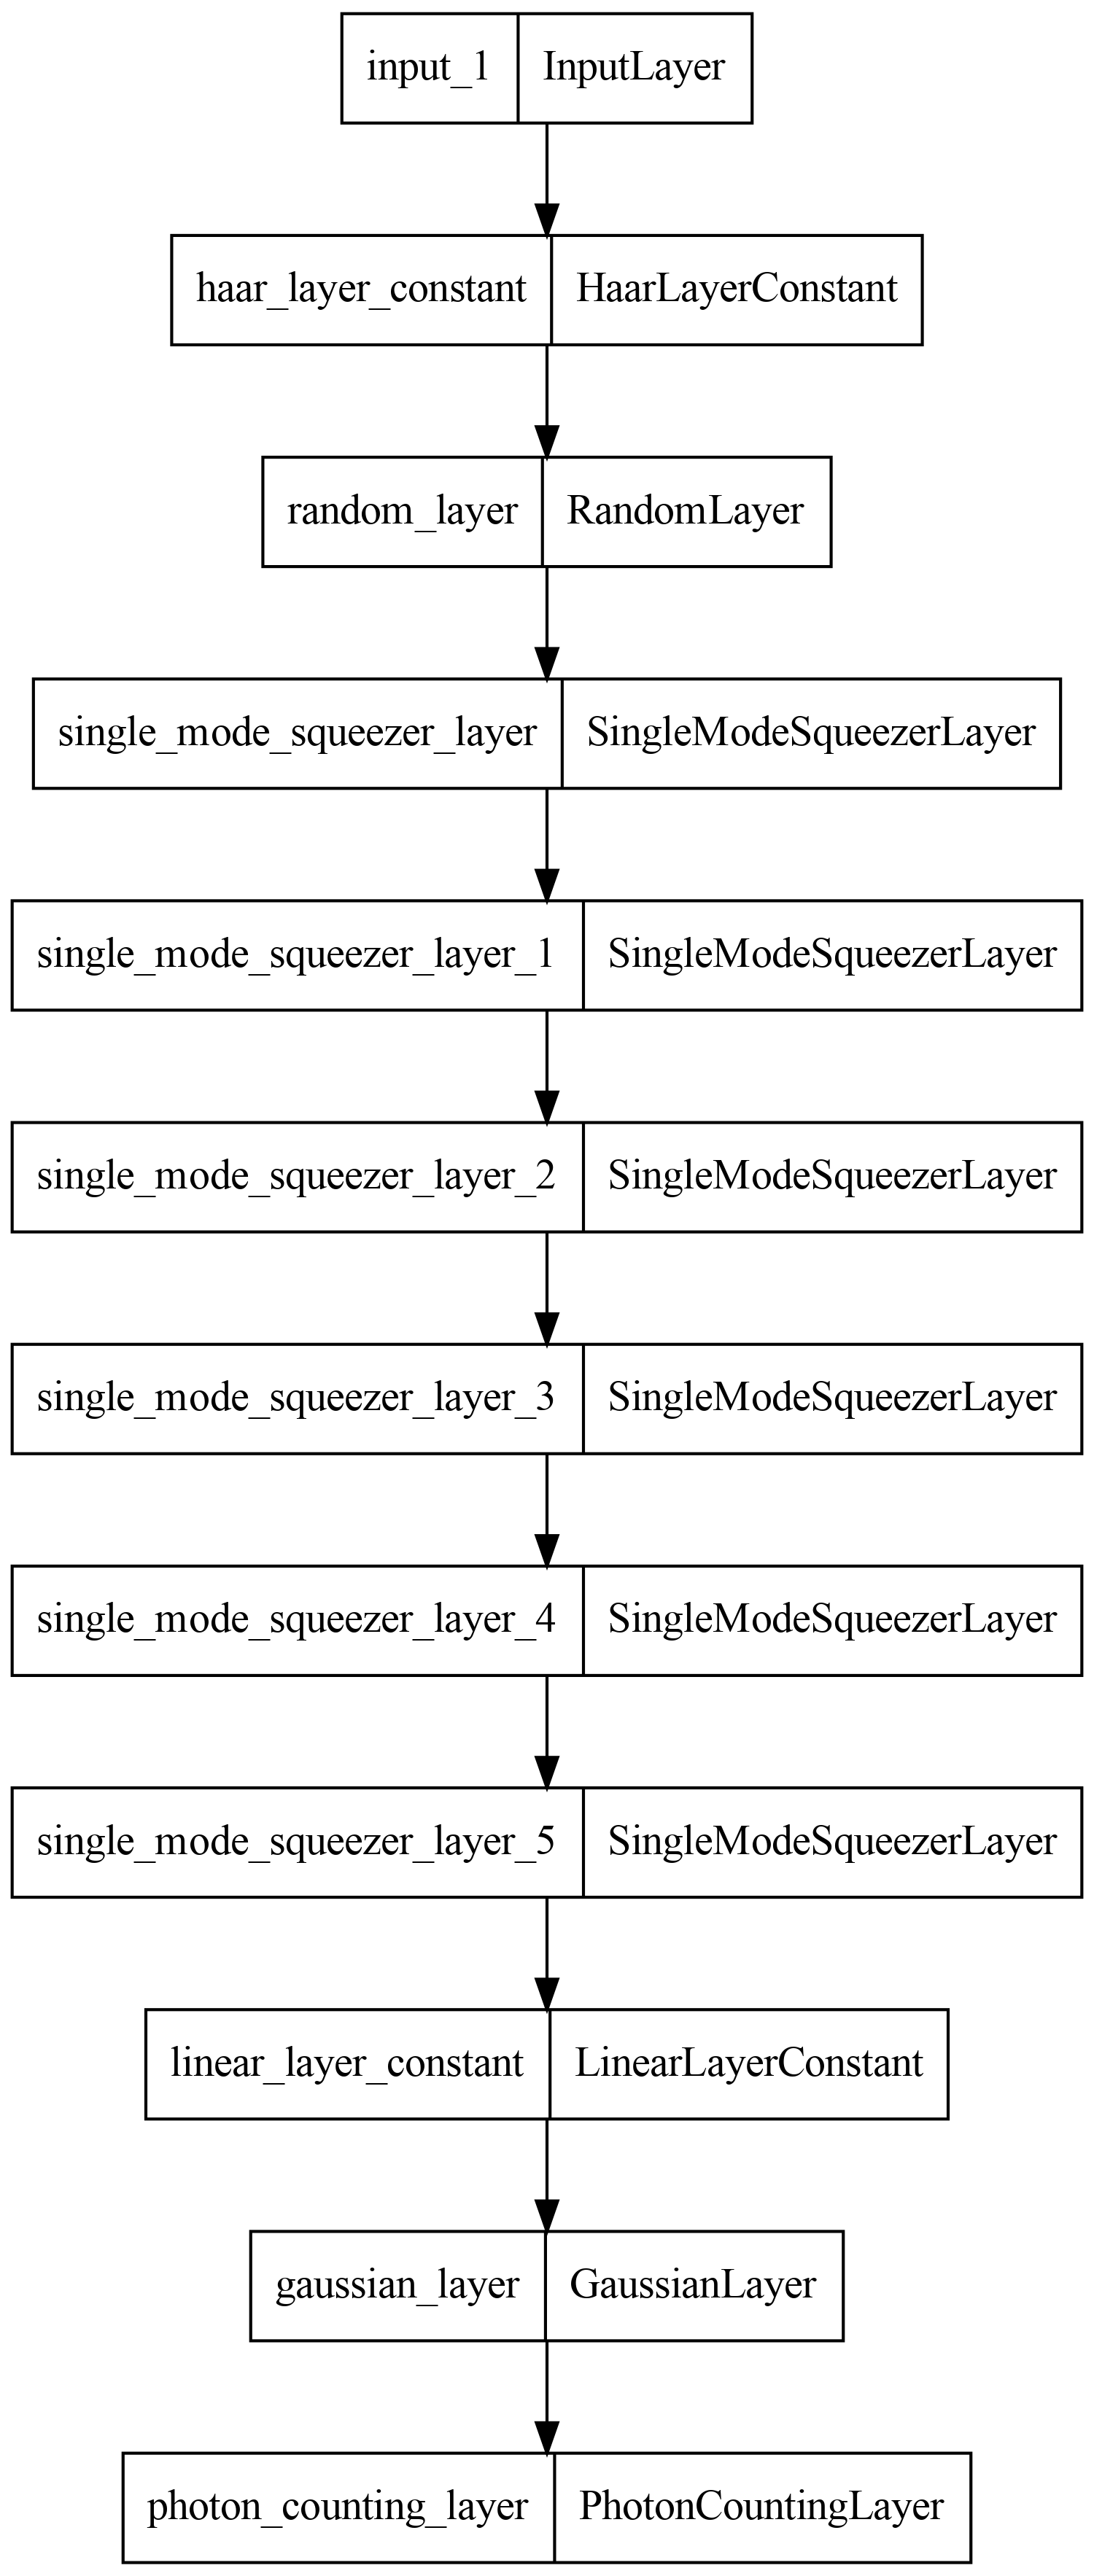

In [23]:
tf.keras.utils.plot_model(
    Nphoton, to_file='modelBS7.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=300,
    layer_range=None, show_layer_activations=False
)

In [24]:
# Plot the model in a pdf file
tf.keras.utils.plot_model(
    Nphoton, to_file='modelBS7.pdf', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=300,
    layer_range=None, show_layer_activations=False
)

## Model with the target output to train

Model with the custom ouput to train

In [25]:
n_out0=tf.gather(tf.squeeze(n_out),0) 
n_out1=tf.gather(tf.squeeze(n_out),1)
min_out=tf.exp(-n_out0-n_out1)
Train_model = tf.keras.Model(inputs = xin, outputs=min_out) # define the model with inputs and ouputs

Add loss to the model as the value of the min_out tensor

In [26]:
Train_model.add_loss(min_out)
Train_model.compile(optimizer='Adam')

Alternative method : Define the custom loss to train the model for maximum output

In [27]:
#def custom_loss(yt,yp):
    # the loss only return the output of the network yp
    # that need to be minimized
#    return yp
#Train_model.compile(loss=custom_loss, optimizer='Adam')

# Transform model

In [28]:
kin, Qrho =ps.getQTransformModel(model)

In [29]:
Qrho.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 q_transform_layer (QTransfo  (None, None)             240       
 rmLayer)                                                        
                                                                 
Total params: 240
Trainable params: 72
Non-trainable params: 168
_________________________________________________________________


Note that the Qrho model summary does not include the previous model but retain the number of trainable parameters

# Test the Pr operator 

Probability of zero photon

In [30]:
%%time
ps.Pr([0]*nmodes, Qrho)

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 9.81 ms


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0062]], dtype=float32)>

Probability of two photons

In [31]:
%time
nbar = [0]*nmodes
nbar[0]=2
print(nbar)
tf.print(ps.Pr(nbar, Qrho))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
[2, 0, 0, 0, 0, 0]
[0.000599483785]


# Generate all the possible photon patterns assuming max one photon per mode

In [32]:
def patterns(nphotons, nmodes):
    # Return the patterns of nmodes with maximal nphotons
    
    # generate a list of zero
    l1=[0]*nmodes
    # set nphotons 1
    for j in range(nphotons):
        l1[j]=1
    # compute all the permutations (zeros and one are distinguishable)
    nlist=it.permutations(l1,nmodes) # return iterators
    # convert to list the iterators
    ln=list(nlist)
    # sort the list in reverse order to have the patterns with more ones first
    ln.sort(reverse=True)
    # remove duplicates (remove adjactent identical elements after sorting)
    ln=list(ln for ln,_ in it.groupby(ln))
    return ln

In [33]:
%%time
ln =patterns(2,nmodes)
print(ln)
print(len(ln))

[(1, 1, 0, 0, 0, 0), (1, 0, 1, 0, 0, 0), (1, 0, 0, 1, 0, 0), (1, 0, 0, 0, 1, 0), (1, 0, 0, 0, 0, 1), (0, 1, 1, 0, 0, 0), (0, 1, 0, 1, 0, 0), (0, 1, 0, 0, 1, 0), (0, 1, 0, 0, 0, 1), (0, 0, 1, 1, 0, 0), (0, 0, 1, 0, 1, 0), (0, 0, 1, 0, 0, 1), (0, 0, 0, 1, 1, 0), (0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 1, 1)]
15
CPU times: user 529 µs, sys: 96 µs, total: 625 µs
Wall time: 598 µs


## Make a plot versus the probability

Build an array of photon number sampling

In [34]:
%%time
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print('Computed by the neural network: '+repr(Pn[nbar]))
    print('--------------------')
    xaxis[nbar]=nbar #store for plot 
print('Done')

Sample 0 of 15 (1, 1, 0, 0, 0, 0)
Computed by the neural network: 0.002311647
--------------------
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
Computed by the neural network: 0.0014033323
--------------------
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
Computed by the neural network: 0.00028550933
--------------------
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
Computed by the neural network: 0.0038723738
--------------------
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
Computed by the neural network: 0.0014427347
--------------------
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
Computed by the neural network: 0.0004238533
--------------------
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
Computed by the neural network: 0.0009175511
--------------------
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
Computed by the neural network: 0.0022557443
--------------------
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
Computed by the neural network: 0.0018162859
--------------------
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
Computed by the neural network: 0.00039943593
--------------------

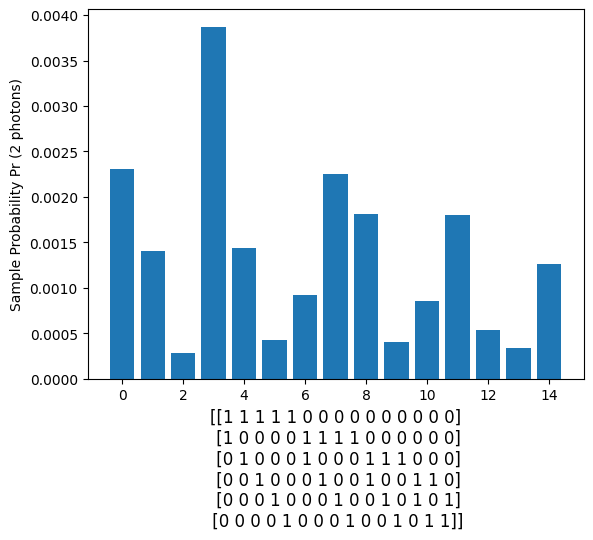

In [35]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (2 photons)');
# save figure in pdf
plt.savefig('BS7pairsnotraining.pdf', 
            format='pdf', bbox_inches='tight')


## Patterns with 4 photons

In [36]:
%%time
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar+1)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')


15
Sample 1 of 15 (1, 1, 1, 1, 0, 0)
0.00051704794
Sample 2 of 15 (1, 1, 1, 0, 1, 0)
0.0003183959
Sample 3 of 15 (1, 1, 1, 0, 0, 1)
0.00049923477
Sample 4 of 15 (1, 1, 0, 1, 1, 0)
2.0100018e-05
Sample 5 of 15 (1, 1, 0, 1, 0, 1)
0.00071448775
Sample 6 of 15 (1, 1, 0, 0, 1, 1)
0.00022018519
Sample 7 of 15 (1, 0, 1, 1, 1, 0)
7.2690396e-05
Sample 8 of 15 (1, 0, 1, 1, 0, 1)
0.00021110984
Sample 9 of 15 (1, 0, 1, 0, 1, 1)
0.00032798867
Sample 10 of 15 (1, 0, 0, 1, 1, 1)
0.00030649445
Sample 11 of 15 (0, 1, 1, 1, 1, 0)
0.00055848394
Sample 12 of 15 (0, 1, 1, 1, 0, 1)
0.00034039174
Sample 13 of 15 (0, 1, 1, 0, 1, 1)
5.0861065e-05
Sample 14 of 15 (0, 1, 0, 1, 1, 1)
4.0041712e-05
Sample 15 of 15 (0, 0, 1, 1, 1, 1)
3.9695573e-05
Done
CPU times: user 46.8 s, sys: 3.33 ms, total: 46.8 s
Wall time: 46.8 s


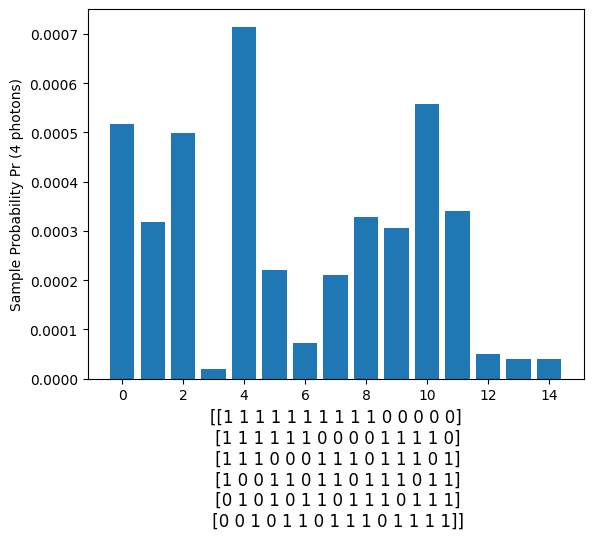

In [37]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (4 photons)');
plt.savefig('BS7quaternotraining.pdf', 
            format='pdf',bbox_inches='tight')

## Compute the probability of pairs 

In [38]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.006241498980671167 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.0023116469383239746 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=0.001403332338668406 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=0.0002855093334801495 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=0.003872373839840293 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=0.0014427347341552377 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=0.0004238532856106758 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=0.0009175511077046394 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=0.0022557443007826805 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=0.0018162858905270696 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.0003994359285570681 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.0008595646941103041 pattern (0, 0, 1, 0

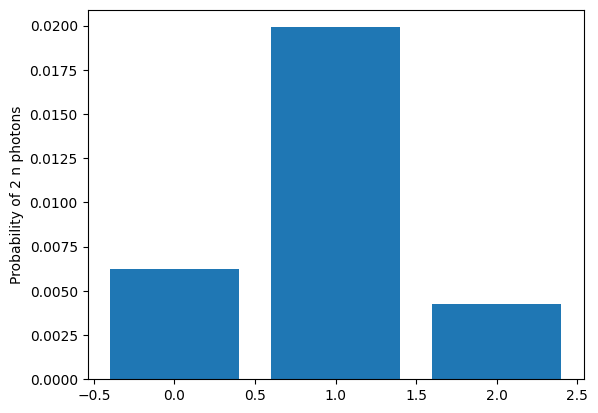

In [39]:
plt.bar(range(nmax+1),probn)
plt.ylabel('Probability of 2 n photons');
plt.savefig('BS7ALLnotraining.pdf',
            format='pdf',bbox_inches='tight') 


# Train the model and recompute probabilities

In [40]:
%%time
history=Train_model.fit(xtrain,np.zeros_like(xtrain),epochs=10000,verbose=0)

CPU times: user 45.1 s, sys: 2.28 s, total: 47.4 s
Wall time: 30 s


Plot training history

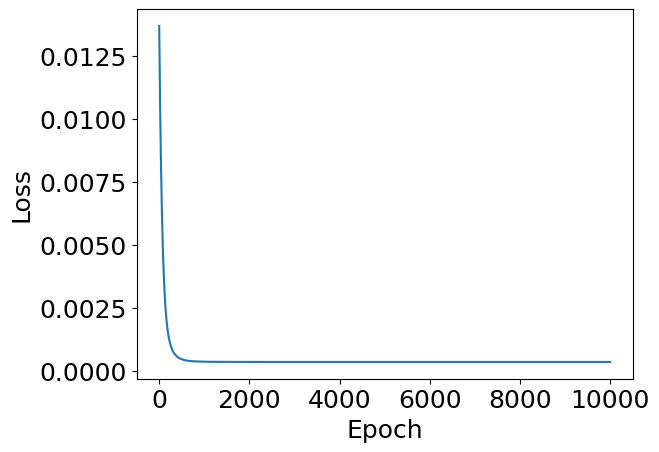

In [41]:
fig =plt.figure()
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot(1, 1, 1)
ax.plot(history.history['loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.savefig('BS7traininghistory.pdf', 
            format='pdf',bbox_inches='tight') 

## Recompute the transform

In [42]:
kin, Qrho =ps.getQTransformModel(model)

## Patterns with 2 photons

In [43]:
%%time
ln =patterns(2,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 0, 0, 0, 0)
0.013597148
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
0.0001793981
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
0.00019538286
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
0.00032871997
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
0.00028411084
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
0.00012852345
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
0.00013997895
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
0.0002355011
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
0.00020354392
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
0.00056228973
Sample 10 of 15 (0, 0, 1, 0, 1, 0)
0.0005011071
Sample 11 of 15 (0, 0, 1, 0, 0, 1)
0.00023142889
Sample 12 of 15 (0, 0, 0, 1, 1, 0)
0.00032070055
Sample 13 of 15 (0, 0, 0, 1, 0, 1)
0.00076979754
Sample 14 of 15 (0, 0, 0, 0, 1, 1)
0.0014134608
Done
CPU times: user 1.58 s, sys: 0 ns, total: 1.58 s
Wall time: 1.58 s


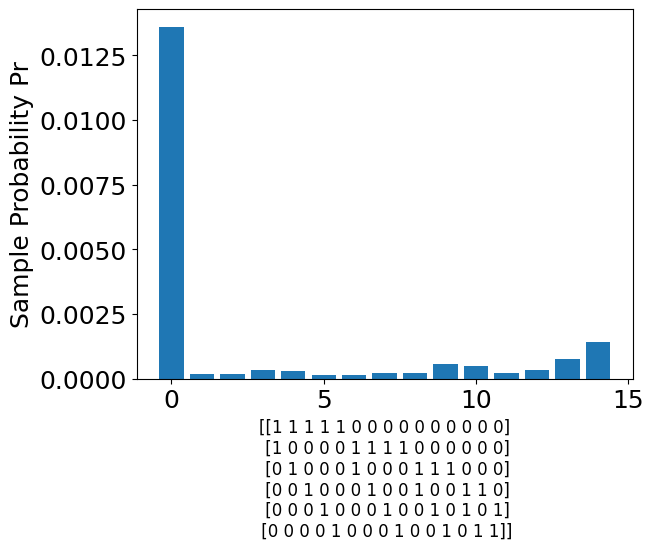

In [44]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr');
plt.savefig('BS7pairstrained.pdf'
            , format='pdf',bbox_inches='tight') 

## Patterns of 4 photons

In [45]:
%%time
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
0.0012142892
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
0.00092176604
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
0.0006056896
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
0.0009951238
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
0.0013011489
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
0.0026761356
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
1.0803458e-05
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
3.0013383e-05
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
3.3652344e-05
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
0.00011204257
Sample 10 of 15 (0, 1, 1, 1, 1, 0)
7.738534e-06
Sample 11 of 15 (0, 1, 1, 1, 0, 1)
2.1500688e-05
Sample 12 of 15 (0, 1, 1, 0, 1, 1)
2.4108202e-05
Sample 13 of 15 (0, 1, 0, 1, 1, 1)
8.026991e-05
Sample 14 of 15 (0, 0, 1, 1, 1, 1)
2.6091606e-05
Done
CPU times: user 45.3 s, sys: 17.9 ms, total: 45.3 s
Wall time: 45.3 s


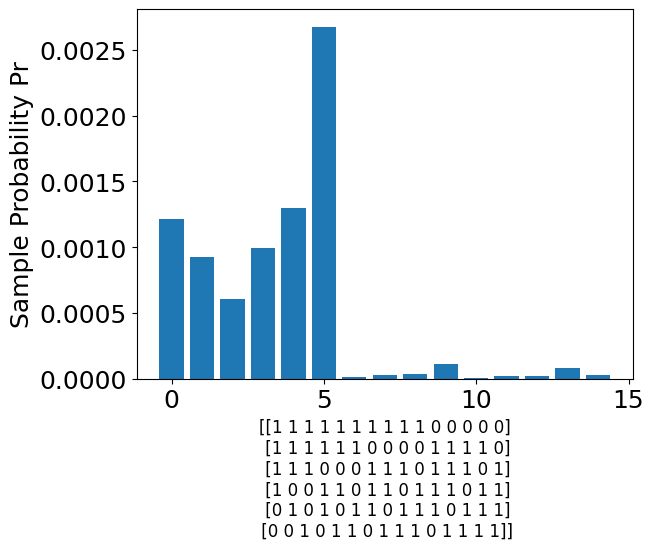

In [46]:
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.bar(range(npatterns),Pn)
plt.ylabel('Sample Probability Pr');
plt.savefig('BS7quatertrained.pdf'
            , format='pdf',bbox_inches='tight') 


# Check the weights of layers

In [47]:
model.layers

In [48]:
tf.print(model.layers[2].get_M())

([[0.148503333 0.190432474 0.0527652502 ... 0.19225347 0.232806802 0.373902261]
 [-0.190432474 0.148503333 -0.389704943 ... 0.363353103 -0.373902261 0.232806802]
 [-0.216804832 -0.22940059 0.591854453 ... -0.0399473757 -0.0817099884 0.669828236]
 ...
 [-0.206023157 0.719630837 -0.0371143632 ... 0.231747448 -0.10843873 0.132297203]
 [0.217369661 -0.263178617 -0.0405288264 ... 0.290746808 0.131767154 0.0595039465]
 [0.263178617 0.217369661 0.0787884593 ... -0.300501913 -0.0595039465 0.131767154]], [[0.148503333 -0.190432474 -0.216804832 ... -0.206023157 0.217369661 0.263178617]
 [0.190432474 0.148503333 -0.22940059 ... 0.719630837 -0.263178617 0.217369661]
 [0.0527652502 -0.389704943 0.591854453 ... -0.0371143632 -0.0405288264 0.0787884593]
 ...
 [0.19225347 0.363353103 -0.0399473757 ... 0.231747448 0.290746808 -0.300501913]
 [0.232806802 -0.373902261 -0.0817099884 ... -0.10843873 0.131767154 -0.0595039465]
 [0.373902261 0.232806802 0.669828236 ... 0.132297203 0.0595039465 0.131767154]])

# Compute the statistical probability of pairs

In [49]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.006241519935429096 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.013597147539258003 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=0.00017939810641109943 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=0.0001953828614205122 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=0.0003287199651822448 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=0.00028411083621904254 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=0.00012852344661951065 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=0.0001399789471179247 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=0.0002355010947212577 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=0.0002035439247265458 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.0005622897297143936 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.0005011070752516389 pattern (0, 0, 

In [50]:
probn

array([0.0062, 0.0191, 0.0081])

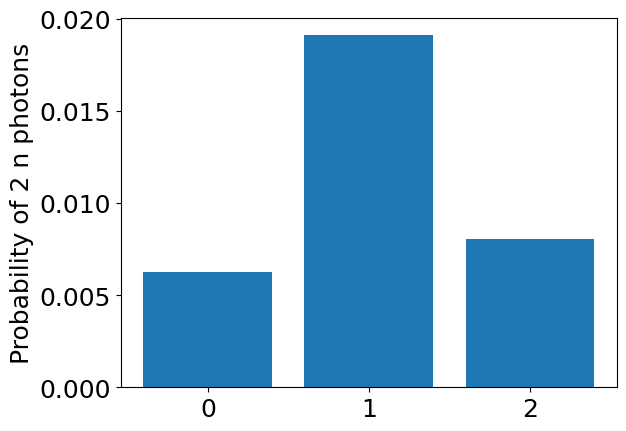

In [51]:
plt.bar(range(nmax+1),probn)
#plt.xlabel(ln, fontsize=6);
plt.ylabel('Probability of 2 n photons');
plt.savefig('BS7ALLtrained.pdf', 
            format='pdf',bbox_inches='tight') 


Looks that the overall probability does not change, but most of the couples appears in the target modes